# Building Makemore

[Video](https://youtu.be/PaCmpygFfXo)

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Explore the dataset

In [2]:
words = open('./names.txt', 'r').read().splitlines()

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

## Part 2: Bigrams Using Probability and Sampling 

### 2.1: Creating Mappings from letter to index

In [5]:
# Mapping from letter to index
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print("Map characters to index:", [ (c, stoi[c]) for c in chars[0:5]])

Map characters to index: [('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5)]


In [6]:
# mapping from index to letter
itos = {i:s for s,i in stoi.items()}
print("Map index to character:", [ (i, itos[i]) for i in range(0,5)])

Map index to character: [(0, '.'), (1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]


### 2.2: Train Bigram Language Model using number of Occurences

In [7]:
# Occurrences matrix
N = torch.zeros((27,27), dtype=torch.int32)

In [8]:
# count bigrams in each word and store in a map
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

Text(0.5, 1.0, 'Occurences of Bigrams in 32,033 Names')

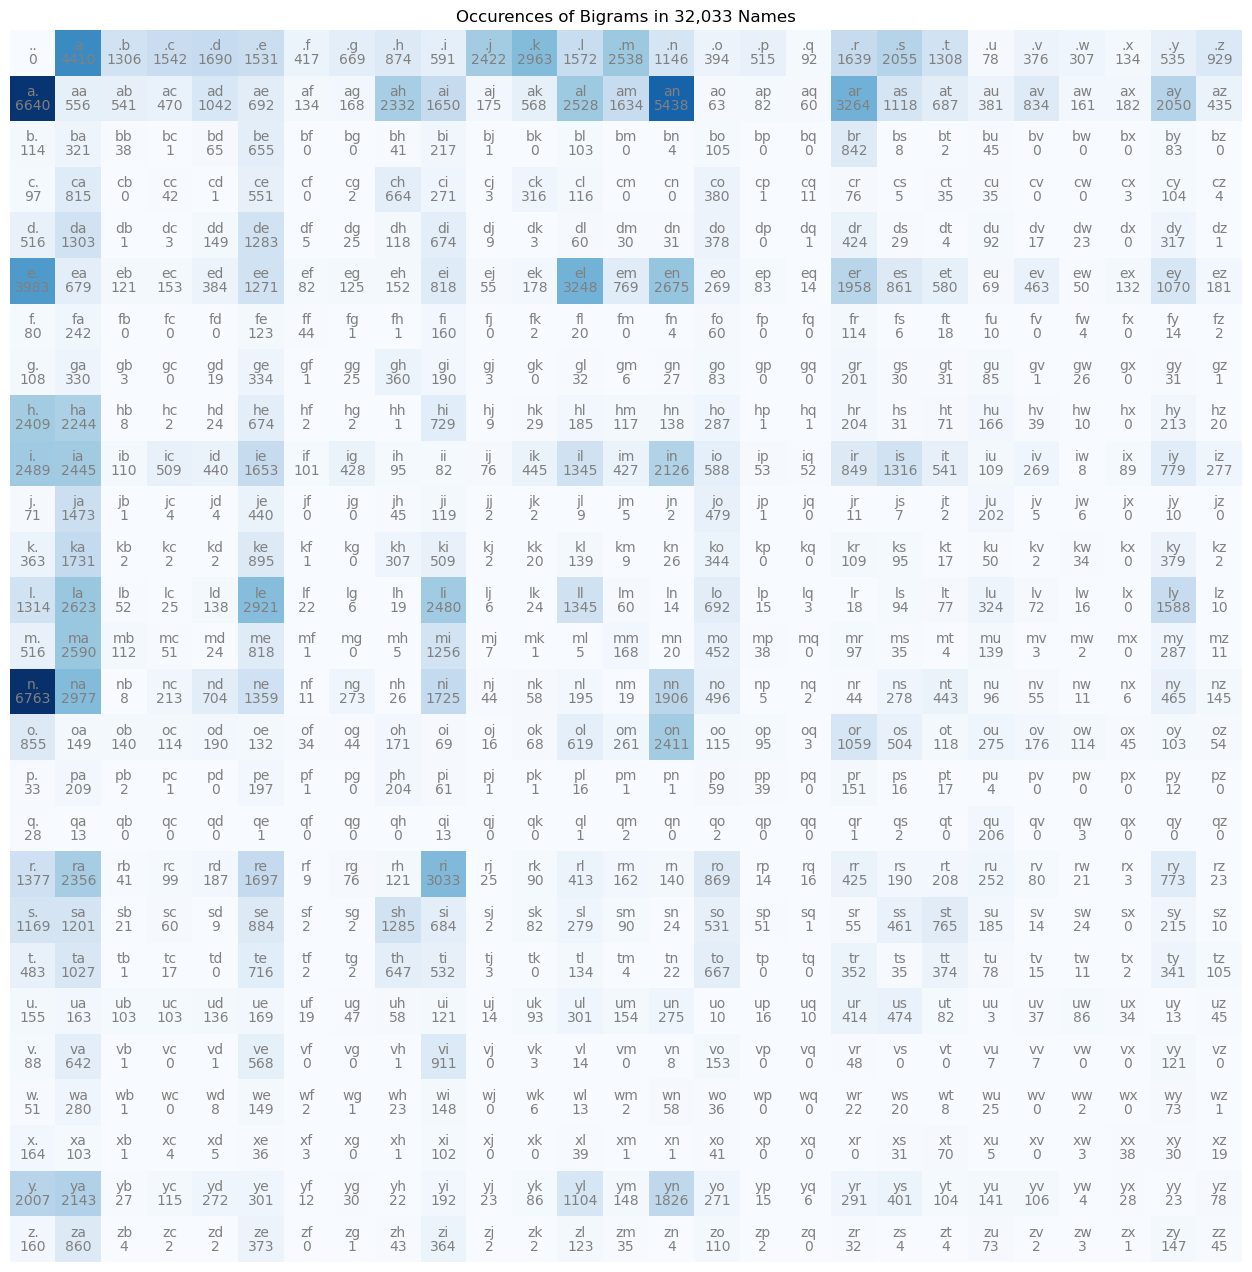

In [9]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.title("Occurences of Bigrams in 32,033 Names")

# Note: Top row is frequency of endings
# Left column is count of startings

### 2.3: Probabilities of word beginnings

Text(0.5, 1.0, 'Probability of each letter beginning a word')

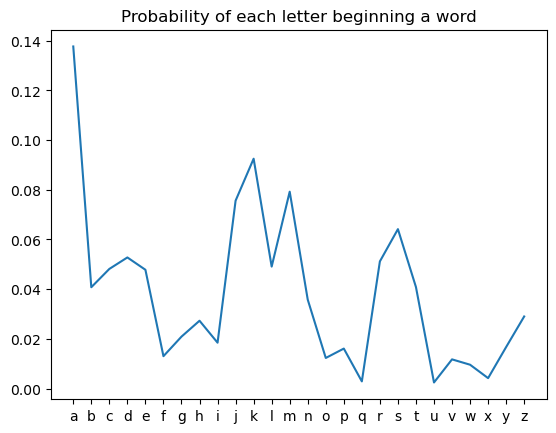

In [10]:
# Probability of word endings of each letter
# where P[i, j] is the probability that letter i will go to letter j
p = N[0].float()
p = p / p.sum()
plt.plot(chars[:], p[1:])
plt.title("Probability of each letter beginning a word")

### 2.4: Using Probability Matrix and Sampling to Generate Names

In [11]:
# Probability Matrix
P = (N+1).float()
P = P / P.sum(1, keepdim=True) # Normalize over rows

In [12]:
# Create 5 sample names
g = torch.Generator().manual_seed(2147483647)
outs = []
for i in range(5):
  out = ""
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out += itos[ix]
    if ix == 0:
      outs.append(out)
      break 
print(outs)

['mor.', 'axx.', 'minaymoryles.', 'kondlaisah.', 'anchshizarie.']


### 2.5: The Loss Function

Our goal is to optimize the product of our matrix' probabilities of each bigram that occurs in the dataset by changing the probabilities in the matrix P

For computational convenience, we will instead optimize the sum of the negative log likelihoods of each bigram in our dataset

Note: `log(a*b*c) = log(a) + log(b) + log(c)`

In [13]:

log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
    n += 1

nll = -log_likelihood

print("Average likelihood of all names according to Probability Matrix:", f'{nll/n:.2f}') # normalized negative log likelihood 

Average likelihood of all names according to Probability Matrix: 2.45


## Part 3: Bigrams Using a Neural Network

#### Note of Caution

`torch.tensor` and `torch.Tensor` are two different datatypes.

lowercase `tensor` will infer the datatype, and uppercase `Tensor` will cast your data to `float32`

### 2.1 One-Hot Encoding

One-Hot Encoding refers to the act of taking an integer, and returning a vector with zeros except for at the i-th index.

In [14]:
# create a new training set for first word 'emma' 
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of training examples:", num)


number of training examples: 228146


Text(0.5, 1.0, "One-hot encoding of 'emma'")

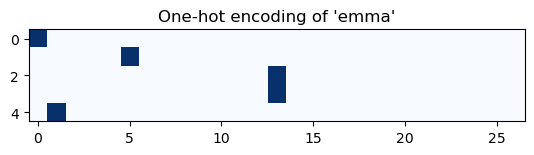

In [15]:
import torch.nn.functional as F

# x encoded as one-hot vectors
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc[:5], cmap='Blues')
plt.title("One-hot encoding of 'emma'")


### 2.2: Backpropagation 

Since we cannot work with counts, discrete integers, as NN outputs, we will instead take the log likelihood, and exponentiate to get a float value that is greater than zero, and this will describe the likelihood of a letter preceding another.

In [16]:
# create a new training set for first word 'emma' 
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of training examples:", num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True) # random weights

number of training examples: 228146


In [17]:
eta = 50 # learning rate
epochs = 100 
for epoch in range(epochs):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # log counts
    counts = logits.exp() # counts
    probs = counts / counts.sum(1, keepdim=True) # probabilities for next character
    # negative log likelihood with regularization
    # note: regularization incentivizes small weights 
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    if epoch % 10 == 0:
        print(f"epoch {epoch}:", loss.item())

    W.grad = None # clear gradients
    loss.backward() # backprop
    W.data += -eta * W.grad # update weights


epoch 0: 3.7686190605163574
epoch 10: 2.6965057849884033
epoch 20: 2.5822560787200928
epoch 30: 2.5413522720336914
epoch 40: 2.52126407623291
epoch 50: 2.509854793548584
epoch 60: 2.5027060508728027
epoch 70: 2.4978787899017334
epoch 80: 2.494438648223877
epoch 90: 2.4918932914733887


In [19]:
g = torch.Generator().manual_seed(2147483647)

print("Sample Outputs of network Using Bigrams:\n================")
for i in range(20):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        # ix = torch.multinomial(probs, replacement=True, num_samples=1, generator=g).item()
        ix = torch.multinomial(probs, replacement=True, num_samples=1).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out)[:-1])

Sample Outputs of network Using Bigrams:
aisi
kaharlylayliddisuey
yoseli
kelliel
eaaiylisa
ttanenigah
ssh
wszalerzann
ma
mawmichialli
rnmiyrins
veranauphiecioth
joloso
coa
misaey
jamaupa
elachanana
hiorb
ston
szoly
